### Case Study 4 : Financial Delinquency

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

In [60]:
from scipy.io import arff
import time
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn import metrics as mt
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import warnings
import getpass


warnings.filterwarnings('ignore')



### Load data from One Drive

In [61]:
current_user = getpass.getuser()

if current_user == 'balaj':
    data_path = "/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/MSDS 7333/Case Study 4/Data"
elif current_user == 'ravis':
    # location of emails
    data_path = "/Users/ravis/Library/CloudStorage/OneDrive-SouthernMethodistUniversity/Case Study 4/Data"
elif current_user == "apurv":
    data_path = "/Users/apurv/Library/CloudStorage/OneDrive-SouthernMethodistUniversity/SMU/7333 - QTW/Case Study 4/Data"

# get all data files
data_files = [f for f in os.listdir(os.getcwd()+'/Data') if os.path.isfile(join(os.getcwd()+'/Data', f))]

In [62]:
data_files

['2year.arff', '3year.arff', '5year.arff', '4year.arff', '1year.arff']

In [6]:
df = pd.DataFrame()

for f in data_files:
    data_temp = arff.loadarff(os.getcwd()+'/Data/'+f)
    temp_df = pd.DataFrame(data_temp[0])
    df = df.append(temp_df, ignore_index=True)


In [7]:
df.shape

(43405, 65)

In [8]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,b'0'
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,b'0'
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,b'0'
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,b'0'
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,b'0'


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43397 non-null  float64
 1   Attr2   43397 non-null  float64
 2   Attr3   43397 non-null  float64
 3   Attr4   43271 non-null  float64
 4   Attr5   43316 non-null  float64
 5   Attr6   43397 non-null  float64
 6   Attr7   43397 non-null  float64
 7   Attr8   43311 non-null  float64
 8   Attr9   43396 non-null  float64
 9   Attr10  43397 non-null  float64
 10  Attr11  43361 non-null  float64
 11  Attr12  43271 non-null  float64
 12  Attr13  43278 non-null  float64
 13  Attr14  43397 non-null  float64
 14  Attr15  43369 non-null  float64
 15  Attr16  43310 non-null  float64
 16  Attr17  43311 non-null  float64
 17  Attr18  43397 non-null  float64
 18  Attr19  43277 non-null  float64
 19  Attr20  43278 non-null  float64
 20  Attr21  37551 non-null  float64
 21  Attr22  43397 non-null  float64
 22

##### Missing value analysis

In [10]:
# Validate null values in the csv file
df.isnull().sum().sum()

41322

In [11]:
pd.set_option('display.max_rows', 100)
# Validate null values in the csv file
print((df.isnull().sum()).sort_values(ascending=False))
# print columns with null values
missing_data_columns = df.columns[df.isnull().any()]
print("\n\nColumns with null values")
print("************************")
missing_data_columns

Attr37    18984
Attr21     5854
Attr27     2764
Attr60     2152
Attr45     2147
Attr24      922
Attr64      812
Attr53      812
Attr28      812
Attr54      812
Attr41      754
Attr32      368
Attr52      301
Attr47      297
Attr46      135
Attr33      134
Attr4       134
Attr40      134
Attr12      134
Attr63      134
Attr19      128
Attr30      127
Attr44      127
Attr43      127
Attr42      127
Attr39      127
Attr49      127
Attr62      127
Attr31      127
Attr23      127
Attr56      127
Attr13      127
Attr20      127
Attr61      102
Attr26       95
Attr16       95
Attr8        94
Attr34       94
Attr17       94
Attr50       94
Attr5        89
Attr58       84
Attr11       44
Attr15       36
Attr9         9
Attr48        9
Attr51        8
Attr1         8
Attr38        8
Attr7         8
Attr35        8
Attr2         8
Attr29        8
Attr25        8
Attr3         8
Attr22        8
Attr36        8
Attr18        8
Attr6         8
Attr14        8
Attr10        8
Attr57        7
Attr59  

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64'],
      dtype='object')

In [12]:
# percentage of missing values in each variable
(df[missing_data_columns].isnull().sum()/len(df)*100).sort_values(ascending=False)

Attr37    43.736897
Attr21    13.486925
Attr27     6.367930
Attr60     4.957954
Attr45     4.946435
Attr24     2.124179
Attr28     1.870752
Attr64     1.870752
Attr53     1.870752
Attr54     1.870752
Attr41     1.737127
Attr32     0.847829
Attr52     0.693468
Attr47     0.684253
Attr46     0.311024
Attr40     0.308720
Attr63     0.308720
Attr33     0.308720
Attr4      0.308720
Attr12     0.308720
Attr19     0.294897
Attr31     0.292593
Attr62     0.292593
Attr56     0.292593
Attr49     0.292593
Attr44     0.292593
Attr43     0.292593
Attr20     0.292593
Attr39     0.292593
Attr13     0.292593
Attr42     0.292593
Attr30     0.292593
Attr23     0.292593
Attr61     0.234996
Attr16     0.218869
Attr26     0.218869
Attr34     0.216565
Attr50     0.216565
Attr17     0.216565
Attr8      0.216565
Attr5      0.205046
Attr58     0.193526
Attr11     0.101371
Attr15     0.082940
Attr9      0.020735
Attr48     0.020735
Attr7      0.018431
Attr22     0.018431
Attr18     0.018431
Attr3      0.018431


In [13]:
top5_missing_data_col = ['Attr37', 'Attr21', 'Attr27', 'Attr60', 'Attr45']
df[top5_missing_data_col].describe()

,Attr37,Attr21,Attr27,Attr60,Attr45
count,24421.000000,37551.000000,4.064100e+04,4.125300e+04,41258.000000
mean,105.085363,3.884997,1.107896e+03,4.480858e+02,14.825016
std,3058.429830,228.668931,3.501237e+04,3.234560e+04,2428.236110
min,-525.520000,-1325.000000,-2.590100e+05,-1.244000e+01,-256230.000000
25%,1.142300,0.908225,4.504800e-02,5.545500e+00,0.019168
50%,3.096300,1.045200,1.084100e+00,9.791700e+00,0.282825
75%,11.414000,1.203700,5.139300e+00,2.018100e+01,0.955588
max,398920.000000,29907.000000,4.208800e+06,4.818700e+06,366030.000000


In [14]:
#fill NA with median() of each column in dataset
df = df.apply(lambda x: x.fillna(x.median()),axis=0)

In [15]:
# Validate null values in the csv file
df.isnull().sum().sum()

0

##### Independent Variable analysis

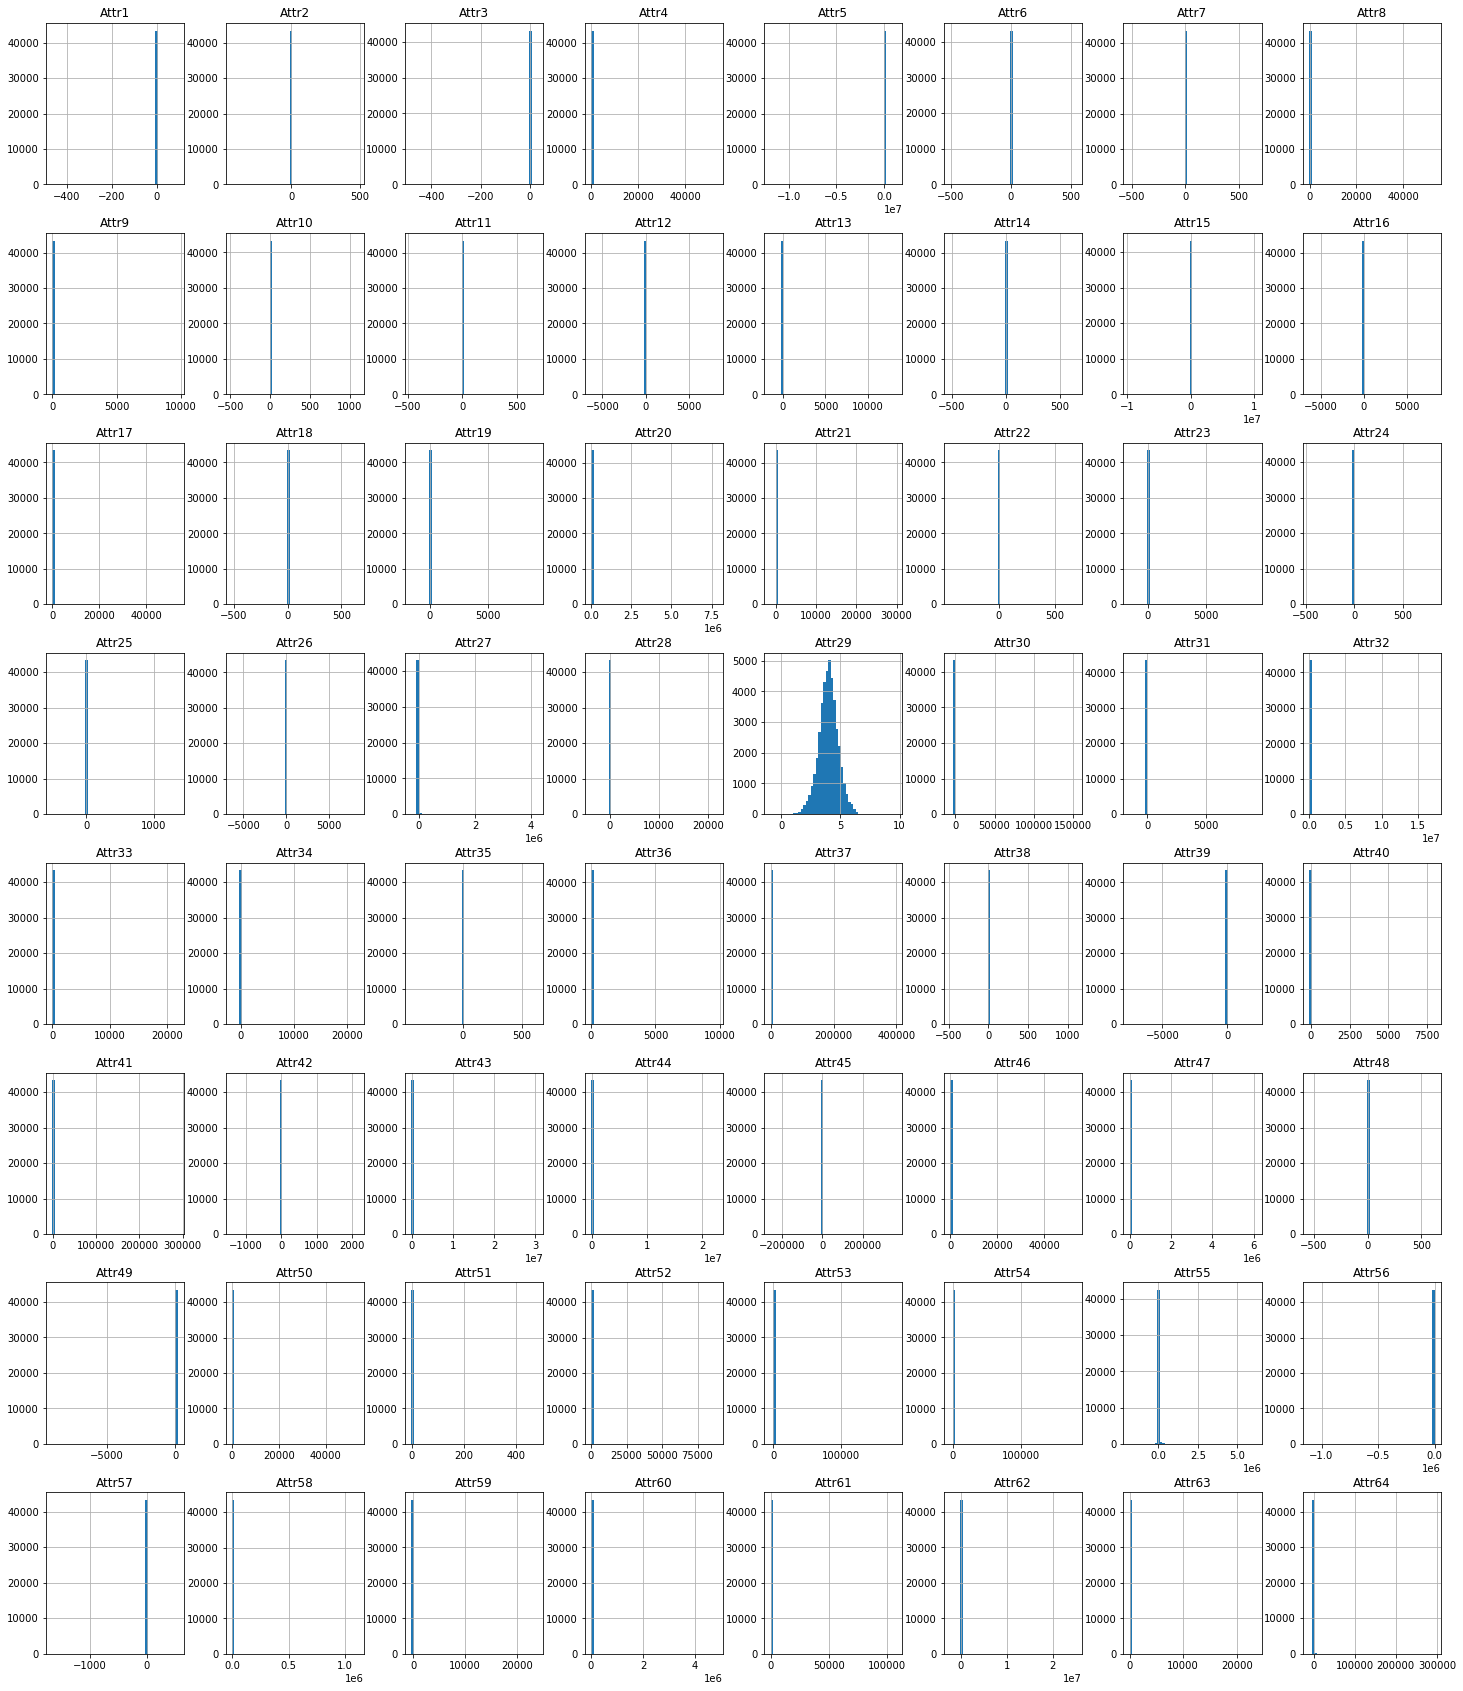

In [16]:
#Visualizing the hist of data to check normality of independent variable
df_X = df.drop(['class'],axis=1)
df_X.hist(bins=50,figsize=(25,30))
plt.show()

Text(0.5, 1.0, 'HeatMap-Correlation Matrix')

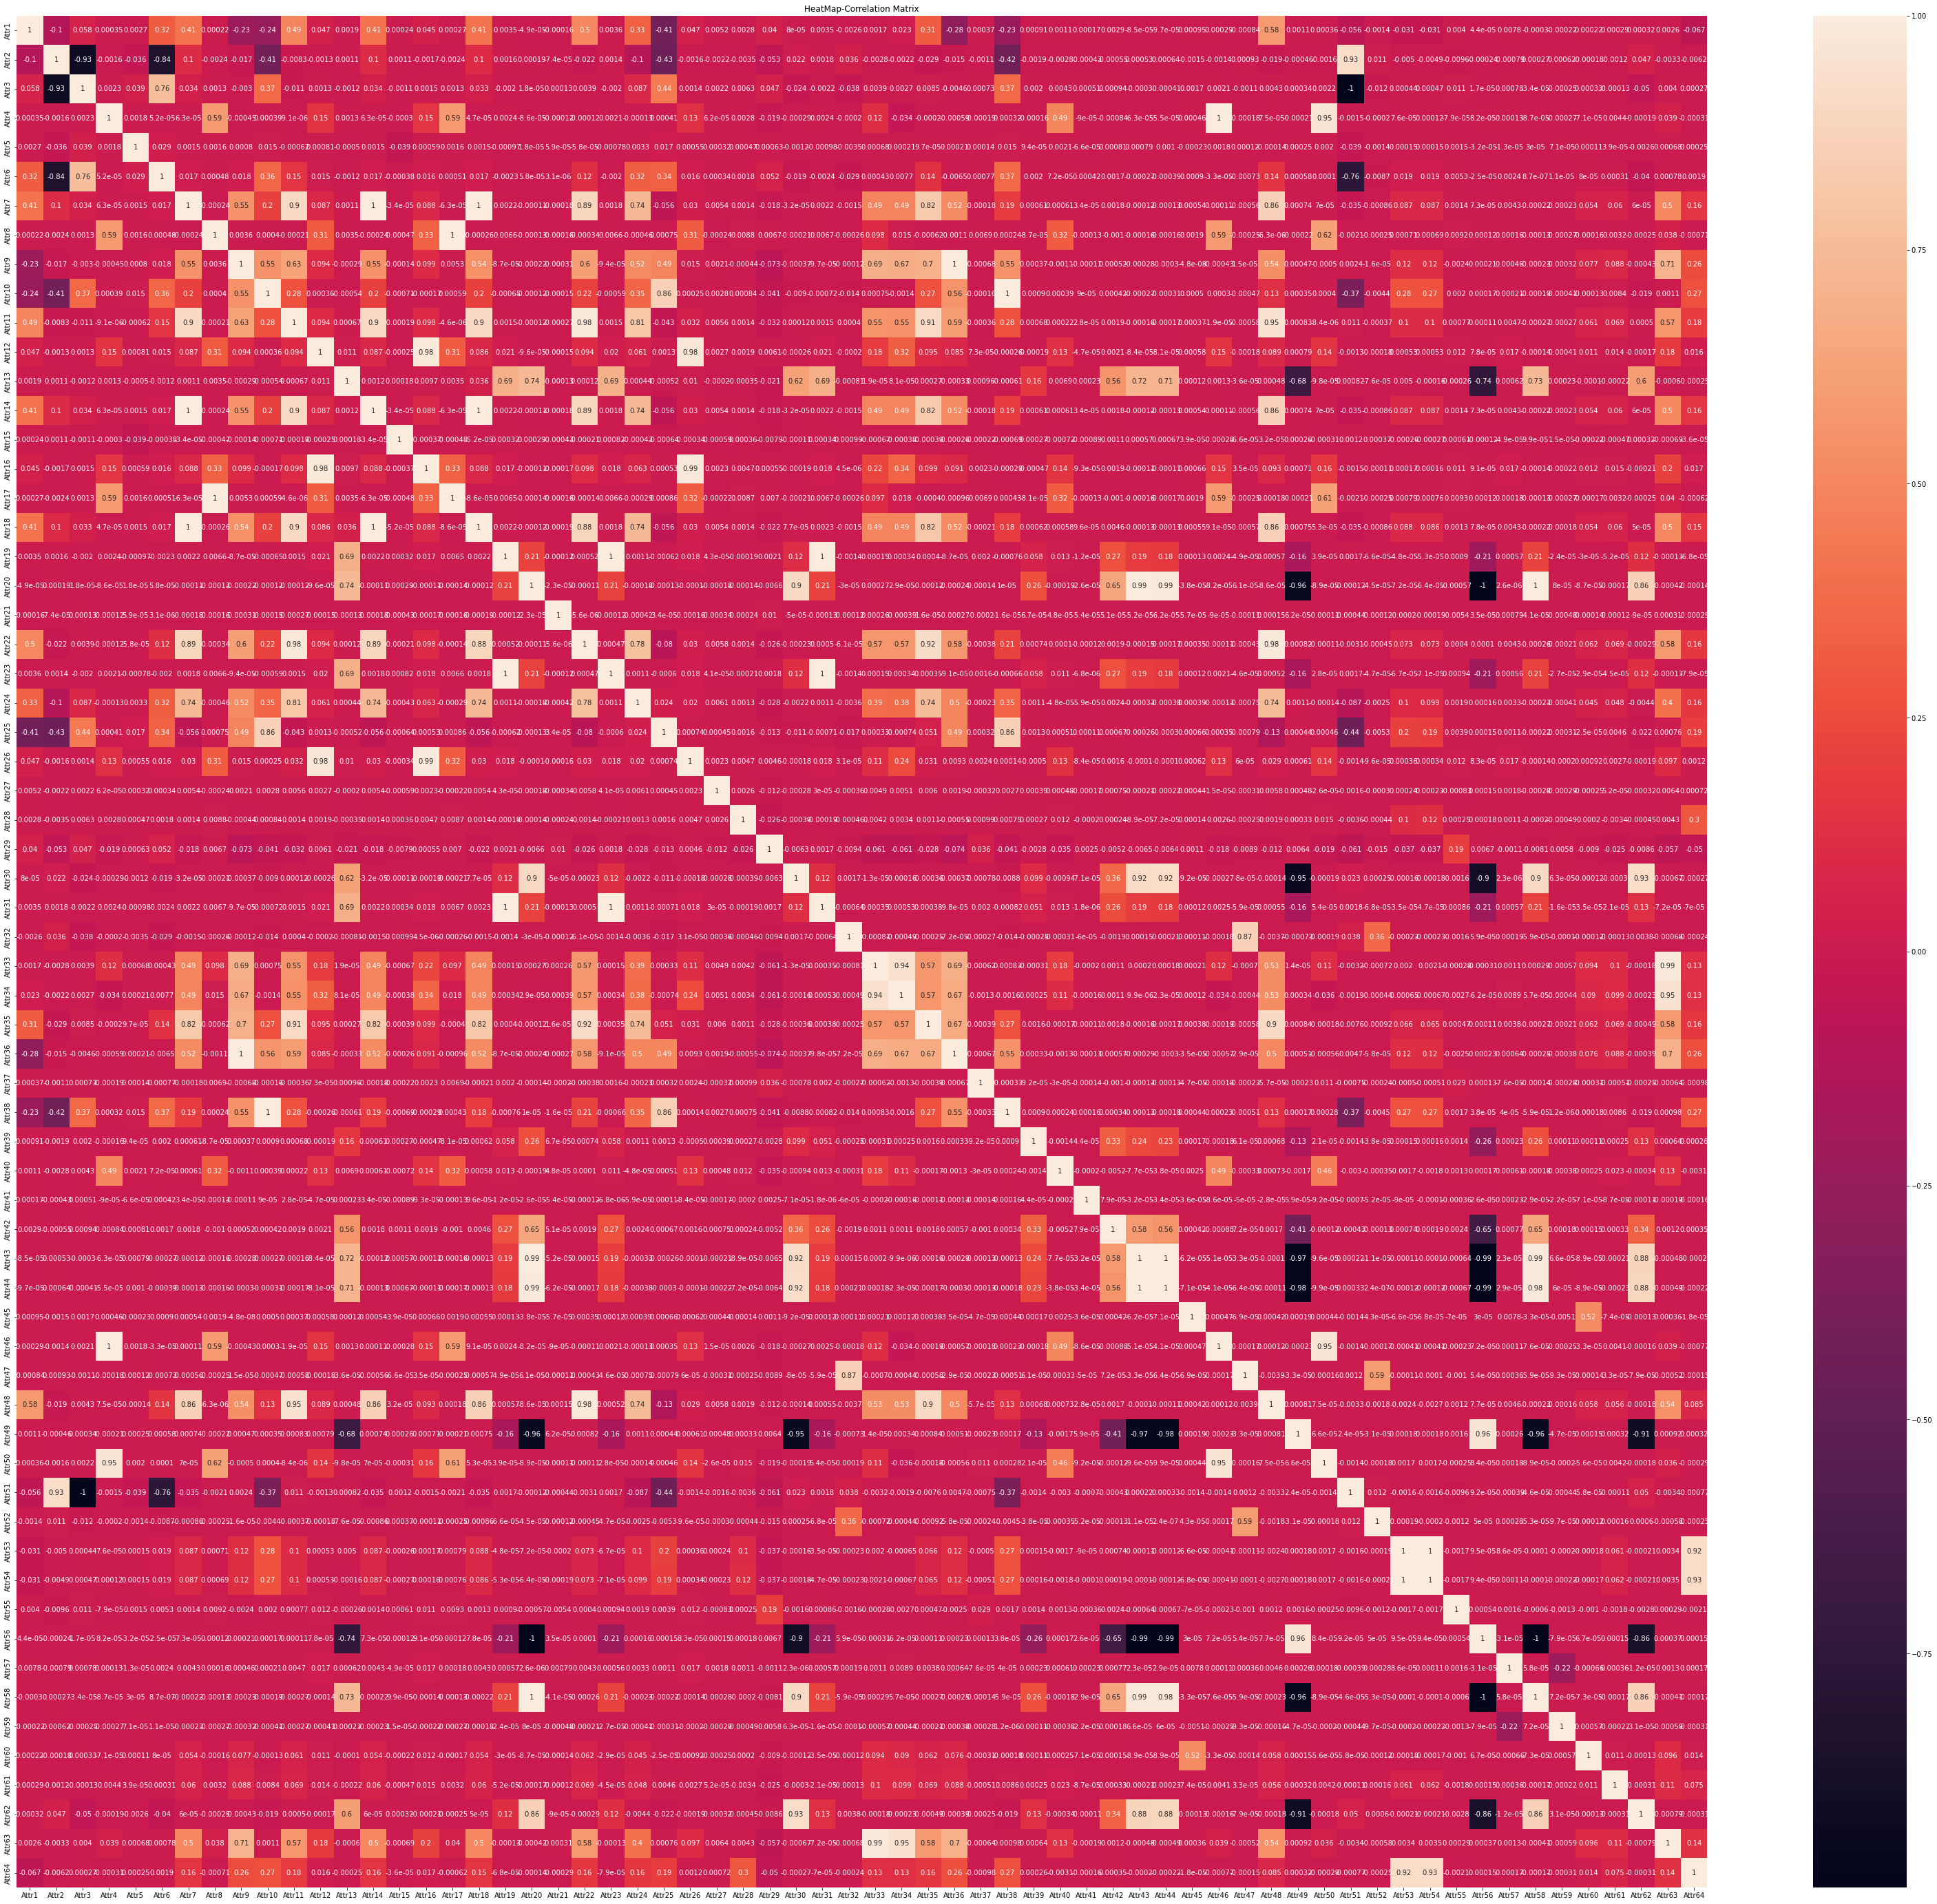

In [17]:
#heatmap - correlation matrix
plt.figure(figsize=(55, 50)) #code reference (5-1)
sns.heatmap(df_X.corr(), annot=True)
plt.title('HeatMap-Correlation Matrix')

##### Check for Multicolliniarity 

In [18]:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
# to drop features with colliniarity more than 95%
pd.set_option('display.max_rows', 100)

corr_df = pd.DataFrame(df_X.corr().abs())
corr_df.head(100)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
Attr1,1.000000,0.104147,0.058037,0.000355,0.002730,3.151388e-01,0.408428,0.000221,2.257200e-01,0.240254,...,0.004014,0.000044,0.007764,3.020252e-04,0.000220,0.000216,0.000295,0.000325,0.002562,0.067120
Attr2,0.104147,1.000000,0.926983,0.001579,0.036196,8.429160e-01,0.102020,0.002380,1.659418e-02,0.409341,...,0.009579,0.000235,0.000793,2.702104e-04,0.000617,0.000180,0.001189,0.046865,0.003318,0.006232
Attr3,0.058037,0.926983,1.000000,0.002321,0.038756,7.602148e-01,0.033521,0.001252,2.981205e-03,0.369558,...,0.011101,0.000017,0.000779,3.419361e-05,0.000247,0.000331,0.000129,0.050155,0.004016,0.000266
Attr4,0.000355,0.001579,0.002321,1.000000,0.001845,5.182356e-05,0.000063,0.589264,4.523560e-04,0.000387,...,0.000079,0.000082,0.000127,8.685419e-05,0.000266,0.000071,0.004374,0.000189,0.039449,0.000312
Attr5,0.002730,0.036196,0.038756,0.001845,1.000000,2.919243e-02,0.001488,0.001624,7.959547e-04,0.014659,...,0.001523,0.000032,0.000013,3.034003e-05,0.000071,0.000106,0.000039,0.002636,0.000682,0.000247
Attr6,0.315139,0.842916,0.760215,0.000052,0.029192,1.000000e+00,0.016701,0.000484,1.774908e-02,0.356794,...,0.005315,0.000025,0.002407,8.710664e-07,0.000011,0.000080,0.000307,0.039644,0.000778,0.001947
Attr7,0.408428,0.102020,0.033521,0.000063,0.001488,1.670137e-02,1.000000,0.000244,5.469279e-01,0.204445,...,0.001421,0.000073,0.004295,2.185134e-04,0.000232,0.053792,0.060095,0.000060,0.503130,0.155092
Attr8,0.000221,0.002380,0.001252,0.589264,0.001624,4.844885e-04,0.000244,1.000000,3.588329e-03,0.000397,...,0.009247,0.000120,0.000155,1.263844e-04,0.000270,0.000164,0.003183,0.000247,0.038304,0.000713
Attr9,0.225720,0.016594,0.002981,0.000452,0.000796,1.774908e-02,0.546928,0.003588,1.000000e+00,0.552239,...,0.002436,0.000208,0.000457,2.297377e-04,0.000322,0.076503,0.087818,0.000434,0.707580,0.257241
Attr10,0.240254,0.409341,0.369558,0.000387,0.014659,3.567941e-01,0.204445,0.000397,5.522394e-01,1.000000,...,0.002029,0.000167,0.000207,1.886191e-04,0.000412,0.000133,0.008407,0.018827,0.001051,0.272010


In [19]:
# Multi Colliniarity analysis on Independent variables 
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool))
print(upper_tri)

        Attr1     Attr2     Attr3     Attr4     Attr5     Attr6     Attr7  \
Attr1     NaN  0.104147  0.058037  0.000355  0.002730  0.315139  0.408428   
Attr2     NaN       NaN  0.926983  0.001579  0.036196  0.842916  0.102020   
Attr3     NaN       NaN       NaN  0.002321  0.038756  0.760215  0.033521   
Attr4     NaN       NaN       NaN       NaN  0.001845  0.000052  0.000063   
Attr5     NaN       NaN       NaN       NaN       NaN  0.029192  0.001488   
Attr6     NaN       NaN       NaN       NaN       NaN       NaN  0.016701   
Attr7     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Attr8     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Attr9     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Attr10    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Attr11    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Attr12    NaN       NaN       NaN       NaN       NaN       NaN       NaN   

/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/ipykernel_67620/1675406197.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool))


In [20]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
print((to_drop))

['Attr14', 'Attr17', 'Attr18', 'Attr23', 'Attr26', 'Attr31', 'Attr36', 'Attr38', 'Attr43', 'Attr44', 'Attr46', 'Attr51', 'Attr54', 'Attr56', 'Attr58']


#### Target

In [21]:
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])

df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

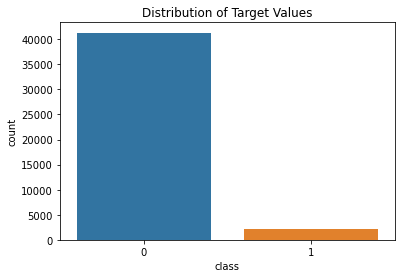

In [22]:
sns.countplot(x = "class", data = df)
plt.title("Distribution of Target Values")
plt.show()

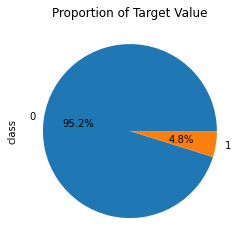

In [23]:
# Pie chart
df['class'].value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

In [24]:
X = df.drop(['class'],axis=1)
ind_columns = df.drop('class',axis=1).columns
y = df['class']

We did normalize the attributes using StandardScaler() to scale them between 0 and 1 before running models.

In [25]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We chose a stratified k-fold validation algorithm. In stratified k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples in which each fold contains roughly the same proportions of class labels. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

The typical standard of 10 folds will be adequate for this dataset

In [26]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

#### helper functions

In [27]:
# Model Metrics
def displayModel_metrics(best_model, grid_model, features, target, cv):   
    start = time.time()
    cv_results = cross_validate(best_model, features, target, cv=cv, scoring=['accuracy','precision','recall'], n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_accuracy'])
    print(' ')
    print('Best Accuracy   :  {:.3f}'.format(grid_model.best_score_))
    print('Mean Accuracy   : ', cv_results['test_accuracy'].mean())
    print('Mean Precision  : ', cv_results['test_precision'].mean())
    print('Mean Recall     : ', cv_results['test_recall'].mean())
    print('Mean Fit Time   : ', cv_results['fit_time'].mean())
    print('Mean Score Time : ', cv_results['score_time'].mean())
    print('CV Time         : ', elapsed_time)
    return

# ROC curve plot
def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()    

#### Model 1: Random Forest with default parameters

In [28]:
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_scaled, y)

rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [29]:
y_hat = rf_clf.predict(X_scaled)
accuracy_score(y_hat, y)

1.0

In [30]:
confusion_matrix(y, y_hat)

array([[41314,     0],
       [    0,  2091]])

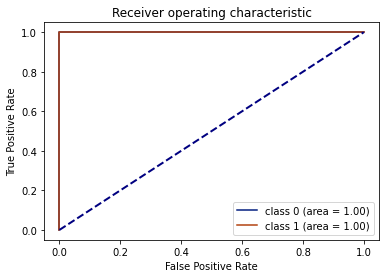

In [31]:
# ROC curve for Random Forest Classifier
roc_curve_plot(rf_clf, X_scaled, y)

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

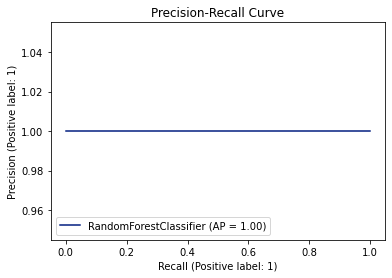

In [32]:
disp = plot_precision_recall_curve(rf_clf, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [33]:
# cross validation
cv_df = pd.DataFrame(cross_validate(rf_clf, X_scaled, y, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
cv_df

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,25.105213,0.069248,0.959687,0.854167,0.196172,0.319066
1,25.181519,0.057062,0.962221,0.826087,0.272727,0.410072
2,24.768619,0.079991,0.958996,0.731343,0.234450,0.355072
3,24.949536,0.062697,0.958765,0.800000,0.191388,0.308880
4,25.492175,0.049337,0.959226,0.789474,0.214286,0.337079
5,25.104751,0.074838,0.961982,0.843750,0.258373,0.395604
6,25.166945,0.059658,0.959447,0.779661,0.220096,0.343284
7,25.366591,0.049118,0.960369,0.911111,0.196172,0.322835
8,25.185577,0.062901,0.961060,0.844828,0.234450,0.367041
9,25.097271,0.073853,0.959447,0.811321,0.205742,0.328244


#### Model 2: Random Forest with GridSearch

Random forest is an ensemble tree-based learning algorithm where it combines more than one algorithms of same or different kind for classifying objects. The Random Forest Classifier is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

Parameters:

- n_estimators: number of trees in the forest

- max_depth: max number of levels in each decision tree

- criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific

- min_samples_split = min number of data points placed in a node before the node is split

- min_samples_leaf = min number of data points allowed in a leaf node

- class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [34]:
RF = RandomForestClassifier()

# define parameters       
max_depth_RF = [5, 7, 8, 10, 12]
random_state_RF = [1234]
n_estimators_RF =  [100]
criterion_RF = ['entropy']
min_samples_leaf_RF = [3, 4, 5]
min_samples_split_RF = [8, 10, 12]
class_weight_RF = ['balanced']

# define grid search
# param_grid_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
#                      criterion=criterion_RF, min_samples_leaf=min_samples_leaf_RF,
#                     min_samples_split=min_samples_split_RF, class_weight=class_weight_RF)

# search_RF = GridSearchCV(estimator=RF, param_grid=param_grid_RF, n_jobs=3, cv=cv, 
#                                scoring='accuracy',error_score=0, verbose=1)


# define random search
param_random_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
                     criterion=criterion_RF, min_samples_leaf=min_samples_leaf_RF,
                    min_samples_split=min_samples_split_RF, class_weight=class_weight_RF)


search_RF = RandomizedSearchCV(estimator=RF, param_distributions=param_random_RF, n_jobs=3, cv=cv, 
                               scoring='accuracy',n_iter=20, verbose=5)

In [35]:
%%time
result_RF = search_RF.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (result_RF.best_score_, result_RF.best_params_))
means = result_RF.cv_results_['mean_test_score']
stds = result_RF.cv_results_['std_test_score']
params = result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.950881 using {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 12, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.850801 (0.007142) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.926022 (0.004501) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.950098 (0.002576) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 12, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.851100 (0.007388) with: {'random_state': 1234, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.925147 (

In [36]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_RF =result_RF.best_estimator_
Coef_weights_RF = result_RF.best_estimator_.feature_importances_
best_Estimator_RF

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_leaf=3, min_samples_split=10,
                       random_state=1234)

In [37]:
# Display model metrics
displayModel_metrics(best_Estimator_RF, result_RF, X_scaled, y, cv)

[CV 3/10] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, random_state=1234;, score=0.862 total time=  12.2s
[CV 4/10] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, random_state=1234;, score=0.851 total time=  12.1s
[CV 7/10] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, random_state=1234;, score=0.855 total time=  12.0s
[CV 10/10] END class_weight=balanced, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=12, n_estimators=100, random_state=1234;, score=0.850 total time=  12.2s
[CV 3/10] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=1234;, score=0.925 total time=  15.3s
[CV 6/10] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_leaf=3, min_samp

Fold Scores:
 
[0.94932043 0.95162405 0.95047224 0.9507026  0.94724718 0.94677419
 0.95276498 0.95506912 0.95138249 0.95345622]
 
Best Accuracy   :  0.951
Mean Accuracy   :  0.9508813510021794
Mean Precision  :  0.49159282034933033
Mean Recall     :  0.5198564593301436
Mean Fit Time   :  22.471777462959288
Mean Score Time :  0.03927977085113525
CV Time         :  23.862152099609375


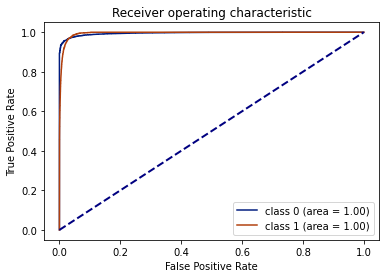

In [38]:
# ROC curve for Random Forest Classifier
roc_curve_plot(result_RF, X_scaled, y)

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

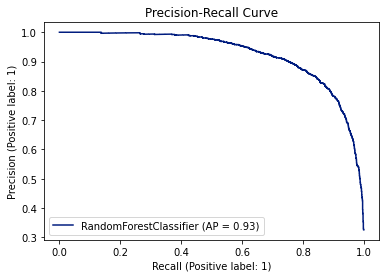

In [39]:
disp = plot_precision_recall_curve(best_Estimator_RF, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

#### Feature Importance

In [40]:
# Important features with their weights 
imp_feature_df = pd.DataFrame({'feature_names':ind_columns, 
                               'Coef_weights':Coef_weights_RF})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
26,Attr27,0.092498
23,Attr24,0.061082
33,Attr34,0.044670
45,Attr46,0.039253
25,Attr26,0.029613
5,Attr6,0.028936
38,Attr39,0.028045
15,Attr16,0.026946
34,Attr35,0.023761
4,Attr5,0.022659


Text(0, 0.5, 'Feature Names')

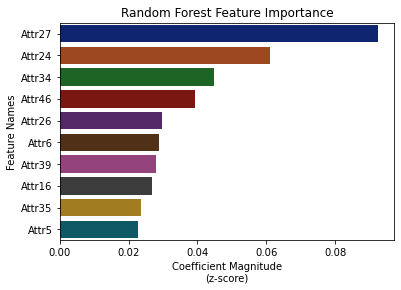

In [41]:
# Visulization of important features 
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df.head(10), orient= 'h')
ax.set_title("Random Forest Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

#### Model 3: XGBoost with default parameters  

In [42]:
xgb_clf = xgb.XGBClassifier()

In [43]:
xgb_clf.fit(X_scaled, y)

xgb_clf.get_params()

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:18] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [44]:
y_hat = xgb_clf.predict(X_scaled)
accuracy_score(y_hat, y)

0.9988480589793802

In [45]:
confusion_matrix(y, y_hat)

array([[41314,     0],
       [   50,  2041]])

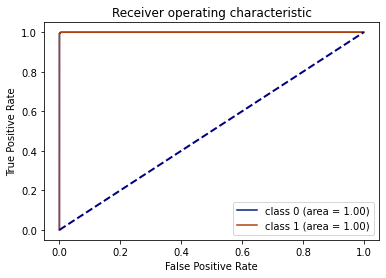

In [46]:
# ROC curve for XGB Classifier
roc_curve_plot(xgb_clf, X_scaled, y)

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

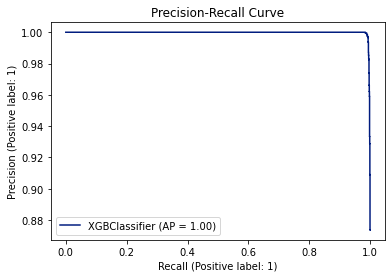

In [47]:
disp = plot_precision_recall_curve(xgb_clf, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

In [48]:
# cross validation
cv_df = pd.DataFrame(cross_validate(xgb_clf, X_scaled, y, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
cv_df

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,37.096681,0.040767,0.977194,0.943548,0.559809,0.702703
1,37.491188,0.018125,0.978346,0.925926,0.598086,0.726744
2,37.311478,0.018643,0.976273,0.889706,0.578947,0.701449
3,37.348850,0.021858,0.979037,0.940299,0.602871,0.734694
4,37.434698,0.016820,0.975121,0.904762,0.542857,0.678571
5,37.032005,0.066828,0.977650,0.924242,0.583732,0.715543
6,37.331496,0.019772,0.976728,0.909091,0.574163,0.703812
7,37.139576,0.031118,0.979493,0.961538,0.598086,0.737463
8,36.932647,0.067514,0.978111,0.959677,0.569378,0.714715
9,37.182781,0.020159,0.976959,0.936000,0.559809,0.700599


#### Model 4: XGBoost with GridSearch

Parameters

- learning_rate: The learning rate. In each boosting step, this values shrinks the weight of new features, preventing overfitting or a local minimum. This value must be between 0 and 1. The default value is 0.3.

- max_depth: The maximum depth of a tree. Be careful, greater the depth, greater the complexity of the model and more easy to overfit. This value must be an integer greater than 0 and have 6 as default.

- n_estimators: The number of trees in our ensemble.

- gamma: A regularization term and it’s related to the complexity of the model. It’s the minimum loss necessary to occur a - -split in a leaf. It can be any value greater than zero and has a default value of 0.

- colsample_bytree: Represents the fraction of columns to be subsampled. It’s related to the speed of the algorithm and prevent overfitting. Default value is 1 but it can be any number between 0 and 1.

- lambda: L2 regularization on the weights. This encourages smaller weights. Default is 1 but it can be any value.

In [49]:
XGB = xgb.XGBClassifier()

# define parameters       
clf_n_estimators_XGB = [100]
clf_learning_rate_XGB =  [0.01, 0.1, 0.2, 0.3]
clf_max_depth_XGB = range(3, 10)
clf_colsample_bytree_XFB = [i/10.0 for i in range(1, 3)]
clf_gamma_XGB = [i/10.0 for i in range(3)]
lambda_XGB = [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]

# define grid search
# param_grid_RF = dict(n_estimators=clf_n_estimators_XGB, learning_rate=clf_learning_rate_XGB, 
#                      max_depth=clf_max_depth_XGB, colsample_bytree = clf_colsample_bytree_XFB,
#                     gamma=clf_gamma_XGB, reg_lambda=lambda_XGB)

# search_RF = GridSearchCV(estimator=RF, param_grid=param_grid_RF, n_jobs=3, cv=cv, 
#                                scoring='accuracy',error_score=0, verbose=1)


# define random search
param_random_XGB = dict(n_estimators=clf_n_estimators_XGB, learning_rate=clf_learning_rate_XGB, 
                     max_depth=clf_max_depth_XGB, colsample_bytree = clf_colsample_bytree_XFB,
                    gamma=clf_gamma_XGB, reg_lambda=lambda_XGB)


search_XGB = RandomizedSearchCV(estimator=XGB, param_distributions=param_random_XGB, n_jobs=3, cv=cv, 
                               scoring='accuracy',n_iter=20, verbose=5)

In [50]:
%%time
result_XGB = search_XGB.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (result_XGB.best_score_, result_XGB.best_params_))
means = result_XGB.cv_results_['mean_test_score']
stds = result_XGB.cv_results_['std_test_score']
params = result_XGB.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[09:37:48] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:48] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:48] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/sr

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

[09:38:26] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, reg_lambda=10.0;, score=0.968 total time=   3.0s
[09:38:29] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/10] END colsample_bytree=0.2, 

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:26] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, reg_lambda=10.0;, score=0.968 total time=   3.0s
[09:38:29] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/10] END colsample_bytree=0.2, 

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

[09:38:26] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/10] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, reg_lambda=10.0;, score=0.970 total time=   3.0s
[09:38:29] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 6/10] END colsample_bytree=0.2, 

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

[09:43:41] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.973621 using {'reg_lambda': 0.1, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.2}
0.968898 (0.001020) with: {'reg_lambda': 10.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.2}
0.973275 (0.001389) with: {'reg_lambda': 5.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.2}
0.963368 (0.000722) with: {'reg_lambda': 0.1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.1}
0.962654 (0.000902)

In [51]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_XGB =result_XGB.best_estimator_
Coef_weights_XGB = result_XGB.best_estimator_.feature_importances_
best_Estimator_XGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [52]:
# Display model metrics
displayModel_metrics(best_Estimator_XGB, result_XGB, X_scaled, y, cv)

[09:40:26] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 8/10] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10.0;, score=0.965 total time=   4.0s
[09:40:30] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10] END colsample_bytree=0.2, 

/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ravis/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:122

Fold Scores:
 
[0.97442985 0.97442985 0.97373877 0.97350841 0.97258696 0.97442396
 0.9702765  0.97304147 0.97511521 0.97465438]
 
Best Accuracy   :  0.974
Mean Accuracy   :  0.9736205370080796
Mean Precision  :  0.9342265296379957
Mean Recall     :  0.4868603326498063
Mean Fit Time   :  9.33867268562317
Mean Score Time :  0.01686382293701172
CV Time         :  10.808622121810913


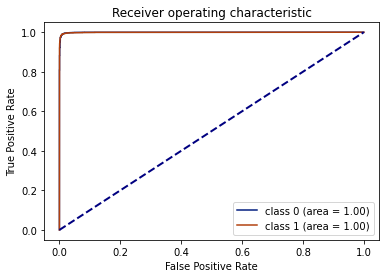

In [53]:
# ROC curve for Random Forest Classifier
roc_curve_plot(result_XGB, X_scaled, y)

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

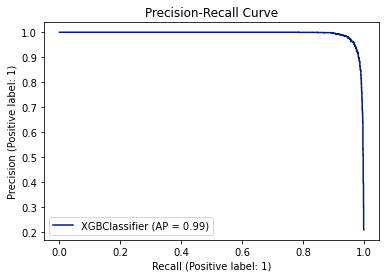

In [54]:
disp = plot_precision_recall_curve(best_Estimator_XGB, X_scaled, y)
disp.ax_.set_title('Precision-Recall Curve')

### Feature Importance with XGB

In [55]:
# Important features with their weights 
imp_feature_df = pd.DataFrame({'feature_names':ind_columns, 
                               'Coef_weights':Coef_weights_XGB})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
26,Attr27,0.061374
33,Attr34,0.032342
21,Attr22,0.029408
45,Attr46,0.028224
38,Attr39,0.028190
23,Attr24,0.028069
57,Attr58,0.026601
34,Attr35,0.026478
15,Attr16,0.023522
55,Attr56,0.023136


Text(0, 0.5, 'Feature Names')

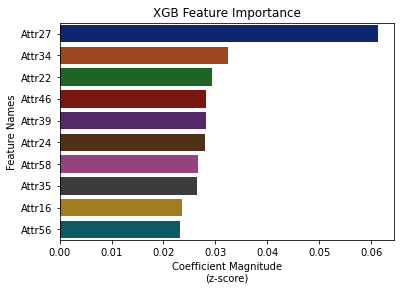

[09:43:49] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:43:49] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:43:49] WARNING: /private/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/pip-install-xsw0zxsq/xgboost_3536fcc7ec224b61b609123814105d36/build/temp.macosx-11.0-arm64-3.9/xgboost/sr

In [56]:
# Visulization of important features 
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df.head(10), orient= 'h')
ax.set_title("XGB Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")